# ⌚️ Inferring Relationships in Wearable-Sourced Health Data

Ths notebook explores, models and attempts to explain latent patterns in data sourced from my Apple Watch. 

❗️ TODO UPDATE THIS LINK TO POINT TO MY COLAB NOTEBOOK

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/local_explanations.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Data

Define an extraction step to ingest the raw data, which we'll skil if the post-processed data is available to avoid oversharing PII.

### Extraction 

Apple stores health data in a proprietary XML format which can be exported in bulk. 

Note: Parsing the HealthKit format below is done with the 

We'll limit the temporal analysis required here by summing within a calendar day. This will yield some reasonable and intuitve metrics we can try to predict off of. The consolidation of the relevant tables is surprisingly straightforward once we apply this constraint: 

HKCategoryTypeIdentifierSleepAnalysis
- on end_date got range hours of sleep 

HKQuantityTypeIdentifierActiveEnergyBurned
- on end_date burned value calories
- sum value by date

HKQuantityTypeIdentifierAppleExerciseTime
- on end_date exercised for 1 min
- sum value by end_date

HKQuantityTypeIdentifierAppleStandTime
- on end_date stood for value mins
- sum value on end_date

HKQuantityTypeIdentifierBasalEnergyBurned
- on end_date calories burned on end_date
- sum value on end_date

HKQuantityTypeIdentifierFlightsClimbed
- on end_date 1 flight climbed 
- sum value on end_date

HKQuantityTypeIdentifierHeartRate
- instantaneous HR measurements at end_date
- perhaps take max value of columnd within date

HKQuantityTypeIdentifierOxygenSaturation
- instantaneous on end date
- take max and min for the day

HKQuantityTypeIdentifierPhysicalEffort
- instanteous measure of energy on end_date
- take max and min for the day 

HKQuantityTypeIdentifierRespiratoryRate
- instantaneous 
- take average? 

HKQuantityTypeIdentifierRestingHeartRate
- value has an average over a short period (length of end_date - start_date)
- take min and max for the day 

HKQuantityTypeIdentifierStepCount
- value for short window 
- sum for end_date

HKQuantityTypeIdentifierTimeInDaylight
- sum value for end_date

In [2]:
INCLUDE_FLAGS = (
    "HKCategoryTypeIdentifierSleepAnalysis",
    "HKQuantityTypeIdentifierActiveEnergyBurned",
    "HKQuantityTypeIdentifierAppleExerciseTime",
    "HKQuantityTypeIdentifierAppleStandTime",
    "HKQuantityTypeIdentifierBasalEnergyBurned",
    "HKQuantityTypeIdentifierFlightsClimbed",
    "HKQuantityTypeIdentifierHeartRate",
    "HKQuantityTypeIdentifierOxygenSaturation",
    "HKQuantityTypeIdentifierPhysicalEffort",
    "HKQuantityTypeIdentifierRespiratoryRate",
    "HKQuantityTypeIdentifierRestingHeartRate",
    "HKQuantityTypeIdentifierStepCount",
    "HKQuantityTypeIdentifierTimeInDaylight",
)

❗️ The library we use for parsing HealthKit data reliese on some enum behavior that wasn't stabilized in python 3.11, however Colab is still running on 3.11 so we can't upgrade. Below GPT-5-supplied workaround to patch enum behavior is necessary if a full parsing operation is run (shoudn't be necessary if running on colab though)

In [3]:
import sys, enum

if (3, 11) <= sys.version_info < (3, 12):
    _old_contains = enum.EnumMeta.__contains__
    def _patched_contains(cls, member):
        # Try the old behavior; if 3.11 raises TypeError for str, emulate 3.12:
        try:
            return _old_contains(cls, member)
        except TypeError:
            try:
                cls(member)  # attempt coercion to Enum
                return True
            except Exception:
                return False
    enum.EnumMeta.__contains__ = _patched_contains


Abstract the XML-based format and emit a dict of dataframes for each of our target tables. 

In [4]:
from apple_health_parser.utils.parser import Parser

def parse_healthkit_data(path, output_dir="./data/out", flags=INCLUDE_FLAGS): 
    """
    Go through the raw data with the help of the above import. 

    NOTE: HealthKit parsing logic courtesy of GPT-5, see https://chatgpt.com/share/68d811d3-6e00-8013-bca7-e39aa6e6f106
    """
    parser = Parser(export_file=path, output_dir=output_dir, overwrite=True)

    flags = [f for f in parser.flags if f.startswith(flags)]

    dfs = {}      # dict[str, pd.DataFrame]  -> all parsed flags you can model from
    errors = {}   # keep going even if a flag fails

    for f in flags:
        try:
            parsed = parser.get_flag_records(flag=f)   # returns ParsedData
            if not parsed.records.empty:
                dfs[f] = parsed.records
        except Exception as e:
            errors[f] = repr(e)

    print(len(dfs), list(dfs)[:8], len(errors))

    return dfs

In [5]:
def aggregate_by_date(df, date_col, val_col, op="sum", name=None):
    """
    Aggregate dataframe column by date, summing

    NOTE:  Date aggregation syntax courtesy of gpt-5, see https://chatgpt.com/share/68d82165-543c-8013-a1c4-4d5ac9d68410
    """
    groups = df.groupby(df[date_col].dt.date)
        
    agg_df = None
    match(op):         
        case "min" : 
            agg_df = groups[val_col].min().reset_index()
        case "max" : 
            agg_df = groups[val_col].max().reset_index()
        case "mean" : 
            agg_df = groups[val_col].mean().reset_index()
        case "sum" | None | _ : 
            agg_df = groups[val_col].sum().reset_index()

    kwargs = { 'columns': [name] } if name else {}
    return pd.DataFrame(agg_df[val_col].values, index=agg_df[date_col].values, **kwargs)

In [6]:
def process_healthkit_data(table_dfs):
    """
    Given a dict of dataframes with our target data container, filter and construct a unifed dataframe 
    that aggregates data by date. Note the tight coupling with parse flags above. 
    """

    agg_dfs = {}
    agg_dfs['sleep'] = aggregate_by_date(table_dfs['HKCategoryTypeIdentifierSleepAnalysis'], date_col="end_date", val_col="range", op="sum", name="sleep_h") 
    agg_dfs['energy'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierActiveEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="active_cal") 
    agg_dfs['exercise'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleExerciseTime'], date_col="end_date", val_col="value", op="sum", name="exercise_h") 
    agg_dfs['stand'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleStandTime'], date_col="end_date", val_col="value", op="sum", name="stand_h") 
    agg_dfs['basal'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierBasalEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="basal_cal") 
    agg_dfs['flights'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierFlightsClimbed'], date_col="end_date", val_col="value", op="sum", name="flights") 
    agg_dfs['hr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierHeartRate'], date_col="end_date", val_col="value", op="max", name="max_hr") 
    agg_dfs['o2'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierOxygenSaturation'], date_col="end_date", val_col="value", op="min", name="min_o2") 
    agg_dfs['effort'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierPhysicalEffort'], date_col="end_date", val_col="value", op="sum", name="activity_mets") 
    agg_dfs['rr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRespiratoryRate'], date_col="end_date", val_col="value", op="mean", name="avg_rr") 
    agg_dfs['resting'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRestingHeartRate'], date_col="end_date", val_col="value", op="mean", name="avg_resting_hr") 
    agg_dfs['step'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierStepCount'], date_col="end_date", val_col="value", op="sum", name="steps") 
    agg_dfs['daylight'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierTimeInDaylight'], date_col="end_date", val_col="value", op="sum", name="daylight_h") 

    # Migrat to float value for sleep duration from timedelta.  NOTE: GPT-5-supplied conversion syntax
    agg_dfs['sleep'].sleep_h = agg_dfs['sleep'].sleep_h / np.timedelta64(1, "h")

    # Join our table DFs
    df = pd.DataFrame()
    df = df.join(list(agg_dfs.values()), how="outer")
    #macro_df.reset_index(names='date', inplace=True)

    # Coax the string value for the date back to a numeric and sort. NOTE: type conversion courtesy of GPT-5
    df.index = pd.to_datetime(df.index, errors="coerce")
    df.sort_index(inplace=True)

    return df

If we can restore the processed data, do so, otherwise mine our data out of the full HealthKit export.

In [7]:
raw_dataset = "./data/export.zip"
processed_dataset = "./data/health.csv"

df = pd.read_csv(processed_dataset)
if df is None: 
    
    # Mine the raw export 
    table_dfs = parse_healthkit_data(raw_dataset)
    df = process_healthkit_data(table_dfs)
    
    # Avoid doing this again on subsequent runs!
    df.to_csv("dataset_path")
    

### Exploration

In [8]:
df

,date,sleep_h,active_cal,exercise_h,stand_h,basal_cal,flights,max_hr,min_o2,activity_mets,avg_rr,avg_resting_hr,steps,daylight_h
0,2018-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.0,NaN
1,2018-04-04,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4615.0,NaN
2,2018-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2996.0,NaN
3,2018-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN
4,2018-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,594.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,2025-09-23,6.082500,504.973,11.0,122.0,1943.365,8.0,100.0,0.94,1541.9,12.441860,50.0,7830.0,42.0
2730,2025-09-24,7.075556,490.431,21.0,95.0,1891.894,19.0,129.0,0.92,1455.4,11.918605,54.0,8274.0,53.0
2731,2025-09-25,5.238611,1086.919,113.0,158.0,1976.054,9.0,163.0,0.93,2089.4,12.046875,56.0,11772.0,110.0
2732,2025-09-26,NaN,1063.219,114.0,185.0,2036.562,41.0,145.0,0.94,2550.7,NaN,56.0,13320.0,160.0


Text(0.5, 1.0, 'Feature density for 2018-04-03 to 2025-09-27')

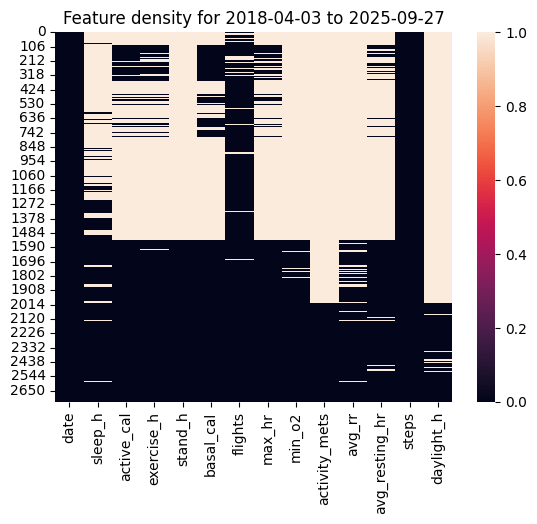

In [29]:
# Inspect for sparsity
ax = sns.heatmap(df.isna())
ax.set_title(f"Feature density for {df.iloc[0].date} to {df.iloc[-1].date}")

There's way too much sparsity in our features to attempt modeling or exploration. Slice this down to a subset that has higher fidelity. 

Text(0.5, 1.0, 'Feature density for 2023-09-26 to 2025-09-26')

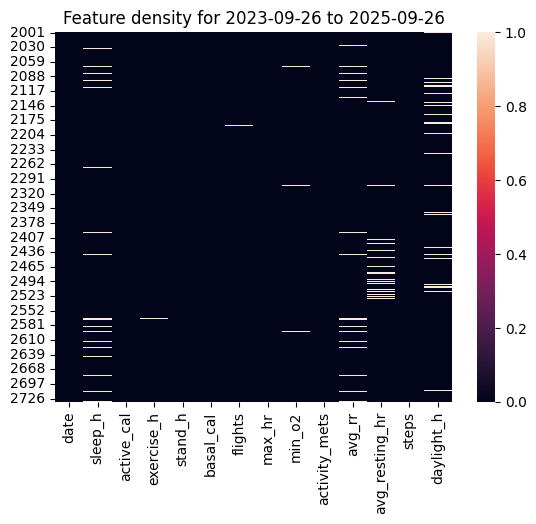

In [27]:
start_ix = df[~df.activity_mets.isna()].index[0]
df2 = df.iloc[start_ix:-1]
ax = sns.heatmap(df2.isna())
ax.set_title(f"Feature density for {df2.iloc[0].date} to {df2.iloc[-1].date}")


Because this is my health data, there are relatively few gaps, and I know, eh ... myself reasonably well, we'll impute values here using the mean for each. 

In [40]:
df2.sleep_h = df2.sleep_h.fillna(value=df2.sleep_h.mean())
df2.exercise_h = df2.sleep_h.fillna(value=df2.exercise_h.mean())
df2.flights = df2.sleep_h.fillna(value=df2.flights.mean())
df2.min_o2 = df2.sleep_h.fillna(value=df2.min_o2.mean())
df2.avg_rr = df2.sleep_h.fillna(value=df2.avg_rr.mean())
df2.avg_resting_hr = df2.sleep_h.fillna(value=df2.avg_resting_hr.mean())
df2.daylight_h = df2.sleep_h.fillna(value=df2.daylight_h.mean())

Text(0.5, 1.0, 'Feature density for 2023-09-26 to 2025-09-26')

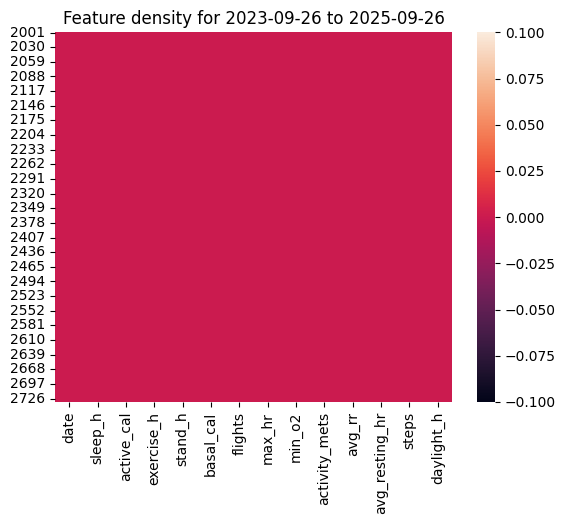

In [42]:
ax = sns.heatmap(df2.isna())
ax.set_title(f"Feature density for {df2.iloc[0].date} to {df2.iloc[-1].date}")

We now have a glorious Nan-free dataset that spans two years (exactly, wow!)

In [46]:
corr = df2.drop(["date"], axis=1).corr()
corr

,sleep_h,active_cal,exercise_h,stand_h,basal_cal,flights,max_hr,min_o2,activity_mets,avg_rr,avg_resting_hr,steps,daylight_h
sleep_h,1.000000,-0.114384,1.000000,0.013139,0.126034,1.000000,-0.228777,1.000000,-0.012041,1.000000,1.000000,0.099717,1.000000
active_cal,-0.114384,1.000000,-0.114384,0.724496,0.092317,-0.114384,0.601152,-0.114384,0.757163,-0.114384,-0.114384,0.579186,-0.114384
exercise_h,1.000000,-0.114384,1.000000,0.013139,0.126034,1.000000,-0.228777,1.000000,-0.012041,1.000000,1.000000,0.099717,1.000000
stand_h,0.013139,0.724496,0.013139,1.000000,0.020508,0.013139,0.363482,0.013139,0.865097,0.013139,0.013139,0.716294,0.013139
basal_cal,0.126034,0.092317,0.126034,0.020508,1.000000,0.126034,-0.019854,0.126034,0.077996,0.126034,0.126034,0.015369,0.126034
flights,1.000000,-0.114384,1.000000,0.013139,0.126034,1.000000,-0.228777,1.000000,-0.012041,1.000000,1.000000,0.099717,1.000000
max_hr,-0.228777,0.601152,-0.228777,0.363482,-0.019854,-0.228777,1.000000,-0.228777,0.451887,-0.228777,-0.228777,0.201512,-0.228777
min_o2,1.000000,-0.114384,1.000000,0.013139,0.126034,1.000000,-0.228777,1.000000,-0.012041,1.000000,1.000000,0.099717,1.000000
activity_mets,-0.012041,0.757163,-0.012041,0.865097,0.077996,-0.012041,0.451887,-0.012041,1.000000,-0.012041,-0.012041,0.682718,-0.012041
avg_rr,1.000000,-0.114384,1.000000,0.013139,0.126034,1.000000,-0.228777,1.000000,-0.012041,1.000000,1.000000,0.099717,1.000000


<Axes: >

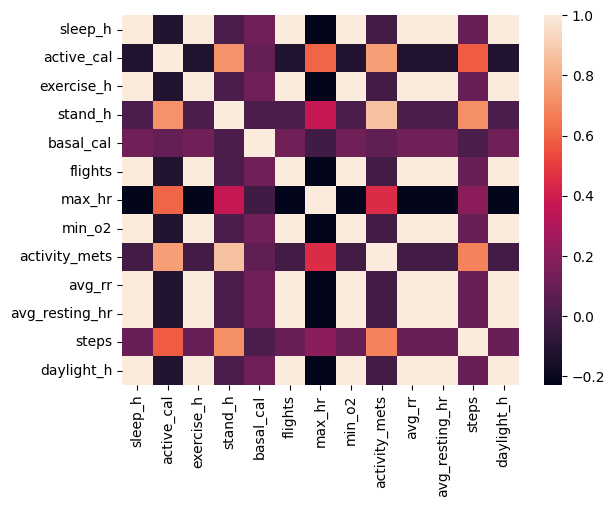

In [47]:
sns.heatmap(corr)